In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel
from scipy import stats
from tqdm import tqdm

from gammapy.spectrum import CountsPredictor

import emcee
import corner


import warnings
# from warnings import RuntimeWarning
# from astropy.utils.exceptions import AstropyWarning
# warnings.filterwarnings('error', category=AstropyWarning, append=True)

# warnings.filterwarnings('ignore', append=True)

from utils import load_spectrum_observations, Log10Parabola, plot_spectra

from IPython.display import display, Math

from scipy.stats import poisson, gamma
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from IPython.display import display, Math


# %load_ext autoreload
# %autoreload 2
%matplotlib inline

I plot the single fit results for the $\beta$ parameter including the estimated standard deviations from the output in the yaml files. This looks just like on would expect and totally fits the countour plots in the paper.


In [ ]:
n_off = 2
b = 0.5*n_off
a = n_off * b +  1

mode = (a - 1) / b
mean = a / b
var = a / b**2

var, mode, mean

In [ ]:
N = 70
stats.poisson.pmf(k=N, mu=N), stats.truncnorm.pdf(N, a=0, b=np.inf, loc=N, scale=10)

In [ ]:
def model_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value


def ln_likelihood(theta, n_on, n_off, alpha):
#     mu_sig, mu_bkg = theta
#     with np.errstate(divide='ignore', invalid='ignore'):
#         a = n_on * np.log(mu_sig + alpha*mu_bkg)
#         b = n_off * np.log(mu_bkg)
    
#     likelihood = a + b - mu_sig - (alpha + 1)*mu_bkg
    
#     t = -2*alpha*mu_bkg - mu_sig
#     likelihood = np.where(n_off == 0,t + a, likelihood)
#     likelihood = np.where(n_on == 0, t + n_off*np.log(alpha) + b, likelihood)
#     likelihood = np.where((n_on == 0) & (n_off == 0), t, likelihood)


    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
        likelihood = -alpha*mu_bkg - mu_sig + n_on * np.log(mu_sig + alpha*mu_bkg)
  
    return likelihood
    

def ln_prior(theta, alpha, n_off):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig, mu_bkg = theta
    with np.errstate(divide='ignore', invalid='ignore'):
#         m = np.sqrt(alpha) / np.sqrt(mu_bkg * (alpha*mu_bkg + mu_sig))
#         m = np.log(m)
#         print(m)
#         scale = 2.5
#         a = -(n_off / scale)
#         try:
#             m = stats.truncnorm.pdf(mu_bkg, a=a, b=np.inf, loc=n_off, scale=np.sqrt(n_off))
#         except ValueError:
#             # this is a scipy bug. see https://stackoverflow.com/questions/46415854/using-numpy-broadcasting-with-scipy-truncnorm
#             m = [stats.truncnorm.pdf(mu, a=c, b=np.inf, loc=n, scale=scale) for mu, c, n in zip(mu_bkg, a, n_off)]
#         m = np.log(m)

        b = 0.5*n_off
        theta= 1 / b
        
        a = n_off * b +  1
        m = gamma.pdf(mu_bkg, a=a, scale=theta)
        m = np.log(m)
#         m = np.zeros_like(mu_sig)
        m[mu_sig < 0] = -np.inf
        m[mu_bkg < 0] = -np.inf
#         print(m)

#     return np.where(mu_sig >= 0, np.log(np.sqrt(1/(mu_sig))), -np.inf) # jeffreys prior would be nice. but how?
    return m


def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta, alpha, n_off)
        prob = prob + lp

    
    return np.where(np.isfinite(prob), prob, 0)


def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]



def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta[0:3]
    if (alpha < 0) or ( alpha > 5) or (beta < 0):
        return -np.inf

    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    start = 3
    for obs in observations:
        try:
            mu_sig = model_prediction(model, obs)
        except:
#             print('--xx'*20)
#             print(mu_sig)
            print(amplitude, alpha, beta)
        
        end = start + len(mu_sig) 
        mu_bkg = theta[start:end]
        start = end
        
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
        obs_alpha=obs.alpha
        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, mu_bkg, n_on, n_off, obs_alpha = apply_range(mu_sig, mu_bkg, n_on, n_off, obs_alpha, bins=bins, fit_range=fit_range)

        prob = ln_prob((mu_sig, mu_bkg), n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            

        obs_probabilities.append(prob)
    return sum(obs_probabilities)

def lllprob(*x):
    c = model_probability(*x)
    if np.isinf(c):
        return -np.inf
    elif c <= 0:
        return -np.inf
    else:
        return np.log(c)

In [ ]:
obs_list, fit_range = load_spectrum_observations('fact')
fit_range, len(obs_list)

In [ ]:
params = np.array([4, 2.4, 0.4])
# params = np.array([3.27344442e+00,  4.26855332e+00,  5.85194023e-01])
# mu_bs = [np.random.poisson(obs.background_vector.data.data.value.astype(np.int) + 1) for obs in obs_list]
mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
theta = np.append(params, 2*np.concatenate(mu_bs))
# print(np.concatenate(mu_bs).shape)
# print('x'*20)
model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)

In [ ]:
N = 20
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
#     t1 = [3.8, alpha, beta]
#     tb = np.random.poisson(obs.background_vector.data.data.value.astype(np.int))
    params = np.array([3.8, alpha, beta])
    mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
    theta = np.append(params, np.concatenate(mu_bs))
    zs.append(model_probability(theta, obs_list, fit_range=fit_range))
    
    params = np.array([3.8, alpha, beta])
    mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
    theta = np.append(params, np.concatenate(mu_bs))
    zs_post.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))

zs = np.array(zs)
zs_post = np.array(zs_post)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=24)
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [ ]:
from scipy.optimize import minimize
# x0 = np.append([3.8, 2.6, 0.4], )
params = np.array([4.2, 2.58, 0.43])
theta = np.append(params, np.concatenate(mu_bs))

# bounds = [(0, 10000) for t in theta]
result = minimize(lambda *x: -lllprob(*x), x0=theta, args=(obs_list, True, fit_range))
result

In [ ]:
labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    txt = f"\mathrm{{{labels[i]}}} = {result.x[i]}"
#     print(labels[i], result.x[i])
#     txt = txt.format(labels[i], result.x[i])
    display(Math(txt))

In [240]:
ndim, nwalkers = len(theta), 2*len(theta)
print(ndim, nwalkers)

pos = np.array([result.x + 0.005 * np.random.randn(ndim) for i in range(nwalkers)])

from multiprocessing import Pool
with Pool(processes=30) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True, fit_range), pool=pool)
    sampler_output = sampler.run_mcmc(pos, 5450, progress=True)

147 294


100%|██████████| 5450/5450 [22:50<00:00,  3.40it/s]


Number of params/dims: 147
shape of samples: (294, 5450, 147)


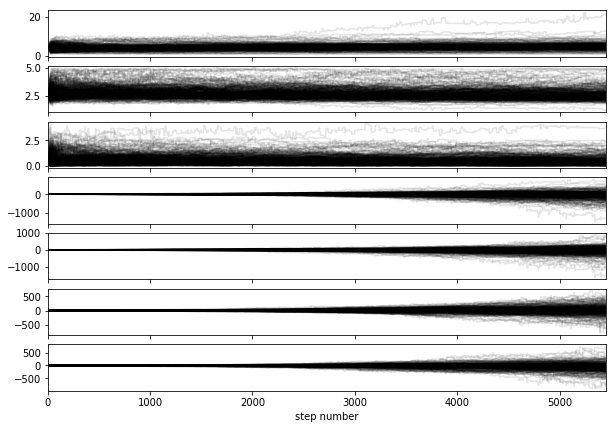

In [241]:
print(f'Number of params/dims: {ndim}')
print(f'shape of samples: {sampler.chain.shape}')
N = 7
fig, axes = plt.subplots(N, figsize=(10, 7), sharex=True)
# labels = ["amplitude", "alpha", "beta"]
for i in range(N):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.1)
    ax.set_xlim(0, len(sampler.chain[0]))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");


In [242]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 147 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 109;
tau: [541.18932248 538.7526619  527.90131429 642.63295971 652.49392432
 636.23321486 640.87528411 657.06616534 636.43567575 640.67268785
 643.06138948 644.57924734 635.88112137 650.23056979 644.86520334
 646.39032679 642.61041949 649.57726671 640.11551442 663.18442225
 533.2948318  531.71368331 532.12711643 536.98857072 519.73142113
 532.93212322 521.79980997 521.77441549 513.30713299 516.88585699
 515.54023084 519.11239995 484.99044662 471.78296814 486.53836634
 636.41842128 506.62160784 495.48559648 652.53637766 475.69057339
 652.42093741 650.49352551 634.80818087 673.8149026  644.32510407
 656.29180261 660.94360399 663.31582385 628.02608095 648.61804472
 654.69019822 680.50934932 648.71515553 650.78810723 649.75594109
 655.41630924 627.41567853 637.85845959 656.22856362 642.40917577
 652.65364726 640.76348946 646.2213401  652.58810217 652.81826696
 642.41365307 635.10931215 649.64328546 645.56064212 646.55499688
 652.06681567 641.72152119 643.42553607 638.2204654  636.15750034
 643.05639061 636.56015521 640.93590095 657.51506019 643.13911275
 655.10317538 642.38636607 637.30227069 645.61579831 634.04829855
 656.01294108 643.63332011 640.86334898 679.24108261 642.16391795
 661.97244505 640.48697062 527.98409711 522.90364058 520.64090922
 515.32395613 531.06027045 528.21068777 515.90547458 529.49350961
 528.47509141 538.68011116 526.31618124 475.70082476 518.50846418
 500.39292335 669.34047074 516.47832203 496.98992475 650.86913491
 451.68546649 657.7057024  528.69808921 618.88791524 654.66760067
 655.00401191 651.1915094  666.3556073  645.27849563 643.42041928
 633.95568025 640.80577322 632.9704198  639.2532451  652.1582129
 645.26922368 646.99878534 639.85893995 644.68427957 651.10967193
 647.57627647 655.90514484 646.1909806  659.05890414 625.75937551
 641.27429046 642.32972724 645.77401013 660.45835244 651.81605806
 643.82146893 657.76400462 633.18454064 655.61944524 648.21638018
 646.25715534 655.7801192 ]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

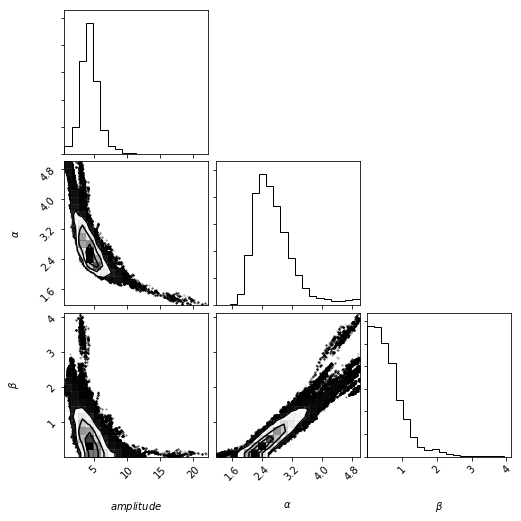

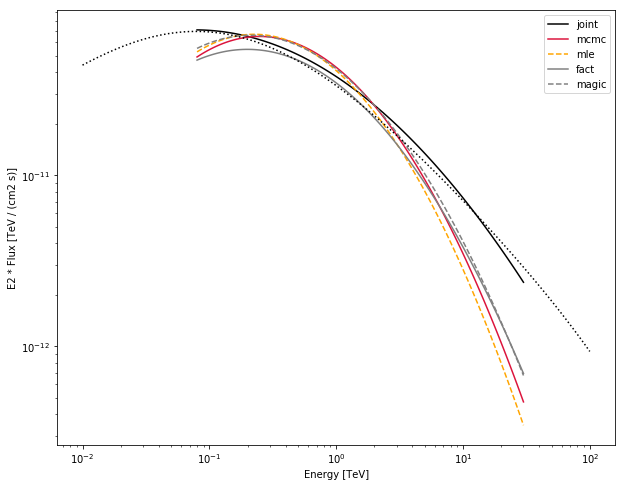

In [243]:
lowest_sample = 800
N = 3
fig = corner.corner(sampler.chain[:, lowest_sample:, :N].reshape([-1, 3]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"])

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, lowest_sample:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

plt.figure(figsize=(10, 8))
plot_spectra(sampler, result, fit_range=fit_range, min_sample=lowest_sample)
plt.legend()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

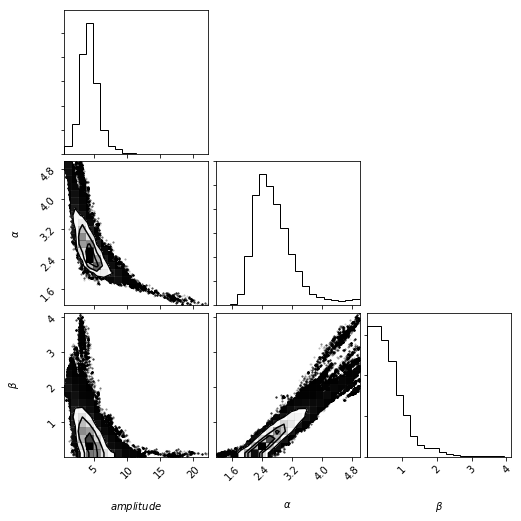

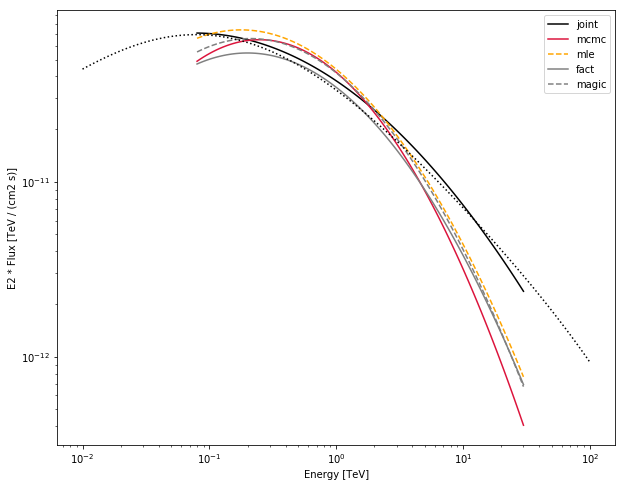

In [244]:
lowest_sample = 100
N = 3
fig = corner.corner(sampler.chain[:, lowest_sample:, :N].reshape([-1, 3]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"])

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, lowest_sample:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

plt.figure(figsize=(10, 8))
result.x = [4.4, 2.6, 0.4]
plot_spectra(sampler, result, fit_range=fit_range, min_sample=lowest_sample)
plt.legend()